# Import Library

In [1]:
import numpy as np
import os
import networkx as nx
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.linalg import fractional_matrix_power

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from layers import GraphConv

#### Configs

In [2]:
DATA_PATH = '../Datasets/cora/'
LOG_PATH = './logs/'
SEED = 42

channels = 16
dropout = 0.5
l2_reg = 5e-4
learning_rate = 1e-2
epochs = 200
es_patience = 10

# Cora Dataset 

In [3]:
all_data = []
all_edges = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data, random_state=SEED)

cora.content
1. Node ID
2. Node Feature
3. Node Label

cora.cites

(a, b)

a : ID of the paper being cited

b : the paper containing the citation

In [4]:
labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    
X = np.array(X, dtype=int)
N = X.shape[0]
F = X.shape[1]
print(f'LOG >>> X shape: {X.shape}')

LOG >>> X shape: (2708, 1433)


In [5]:
edge_list = []

for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))
    
print(f'LOG >>> Number of Nodes N : {N}')
print(f'LOG >>> Number of Features F of each node : {F}')
print(f'LOG >>> Categories :\n{set(labels)}')
num_classes = len(set(labels))
print(f'LOG >>> Number of classes : {num_classes}')

LOG >>> Number of Nodes N : 2708
LOG >>> Number of Features F of each node : 1433
LOG >>> Categories :
{'Reinforcement_Learning', 'Theory', 'Rule_Learning', 'Neural_Networks', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Case_Based'}
LOG >>> Number of classes : 7


# Set Train, val and test mask 

In [6]:
def limit_data(labels, limit=20, val_num=500, test_num=1000):
    label_counter = dict((l, 0) for l in labels)
    train_idx = []
    
    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label] < limit:
            train_idx.append(i)
            label_counter[label] += 1
        
        if all(count == limit for count in label_counter.values()):
            break
            
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num + test_num)]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = limit_data(labels)

In [7]:
print(f'LOG >>> Number of Train set : {len(train_idx)}')
print(f'LOG >>> Number of Valid set : {len(val_idx)}')
print(f'LOG >>> Number of Test set : {len(test_idx)}')

LOG >>> Number of Train set : 140
LOG >>> Number of Valid set : 500
LOG >>> Number of Test set : 1000


In [8]:
train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

### Get Adjacency Matrix, A 

In [9]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [10]:
# plt.figure(figsize=(30, 30))
# nx.draw(G, with_labels=True)
# plt.show()

### Encode label with One-Hot

In [11]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

### Build Graph and get A 

In [12]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

# A = nx.adjacency_matrix(G).todense()
A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [13]:
def normalize_Adj(A):
    I = np.identity(A.shape[0])
    A_hat = A + I
    D = np.diag(np.squeeze(np.array(np.sum(A_hat, axis=0))))
    D_half_norm = fractional_matrix_power(D, -0.5)
    DAD = D_half_norm.dot(A_hat).dot(D_half_norm)
    return DAD

A = normalize_Adj(A)
X = X.astype(np.float64)

### Define Model 

In [14]:
class GCN(tf.keras.Model):
    def __init__(self, filters, dropout):
        super(GCN, self).__init__(name='GCN')
        self.dropout_1 = Dropout(dropout)
        self.graphConv_1 = GraphConv(filters,
                                    activation=tf.nn.relu,
                                    use_bias=False)
        self.dropout_2 = Dropout(dropout)
        self.graphConv_2 = GraphConv(num_classes,
                                    activation=tf.nn.softmax,
                                    use_bias=False)
        
    def call(self, input_tensor, training=False):
        A, x = input_tensor
        x = self.dropout_1(x)
        A, x = self.graphConv_1([A, x])
        x = self.dropout_2(x)
        A, x = self.graphConv_2([A, x])
        return x

In [15]:
model = GCN(channels, dropout)

In [16]:
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

### Callbacks

In [17]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH)
early_stop = tf.keras.callbacks.EarlyStopping(patience=es_patience, restore_best_weights=True)

callbacks = [tensorboard, early_stop]

## Training 

In [25]:
validation_data = ([A, X], labels_encoded, val_mask)

In [26]:
model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

Epoch 1/200
1/1 [==============================] - 0s 380ms/step - loss: 0.0967 - acc: 0.3857 - val_loss: 0.3396 - val_acc: 0.4800
Epoch 2/200
1/1 [==============================] - 0s 389ms/step - loss: 0.0925 - acc: 0.5286 - val_loss: 0.3249 - val_acc: 0.5380
Epoch 3/200
1/1 [==============================] - 0s 285ms/step - loss: 0.0865 - acc: 0.5714 - val_loss: 0.3086 - val_acc: 0.5580
Epoch 4/200
1/1 [==============================] - 0s 280ms/step - loss: 0.0828 - acc: 0.5714 - val_loss: 0.2928 - val_acc: 0.5700
Epoch 5/200
1/1 [==============================] - 0s 274ms/step - loss: 0.0742 - acc: 0.6357 - val_loss: 0.2776 - val_acc: 0.5880
Epoch 6/200
1/1 [==============================] - 0s 283ms/step - loss: 0.0719 - acc: 0.6143 - val_loss: 0.2636 - val_acc: 0.6020
Epoch 7/200
1/1 [==============================] - 0s 284ms/step - loss: 0.0648 - acc: 0.6714 - val_loss: 0.2507 - val_acc: 0.6360
Epoch 8/200
1/1 [==============================] - 0s 279ms/step - loss: 0.0607 - a

### Evaluate 

In [27]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.75      0.75      0.75       113
    Genetic_Algorithms       0.89      0.83      0.86       150
       Neural_Networks       0.85      0.76      0.80       306
 Probabilistic_Methods       0.85      0.77      0.81       167
Reinforcement_Learning       0.73      0.84      0.78        79
         Rule_Learning       0.54      0.79      0.64        62
                Theory       0.55      0.63      0.58       123

              accuracy                           0.76      1000
             macro avg       0.74      0.77      0.75      1000
          weighted avg       0.78      0.76      0.77      1000



###  Get hidden layer representation for GCN

In [36]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

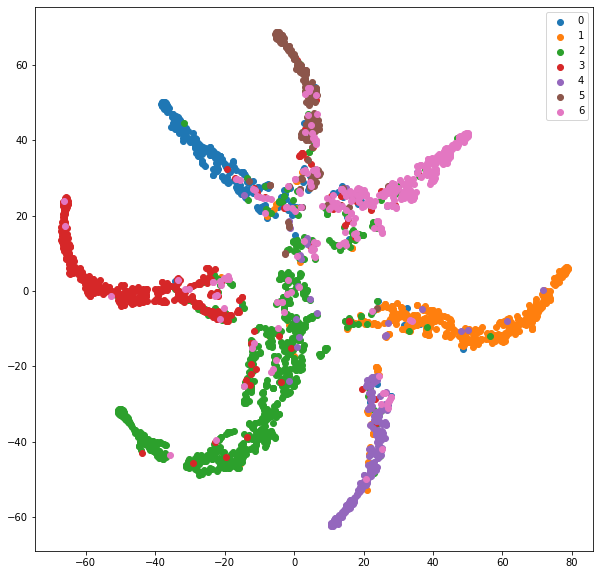

In [37]:
def plot_tSNE(labels_encoded, x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10, 10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices, 0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()

plot_tSNE(labels_encoded, x_tsne)